![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [56]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [57]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [58]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [59]:
# Celda 1 - Funciones para implementar el árbol de decisión manualmente.

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split
    
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [60]:
#Estimación del modelo con las muestras de entrenamiento. Se escoge el valor de max_depth de manera arbitraria.  
tree_ = tree_grow(X_train,y_train, max_depth = 5)

y_predict = tree_predict(X_test, tree_ ) #Predicción en la muesra de prueba (test) 

#Se calcula el Accuracy del modelo con la variable de respuesta de prueba. 
print('El Accuracy del modelo con un max_depth arbitrario de 5 es: ' + str(metrics.accuracy_score(y_predict, y_test))) 

El Accuracy del modelo con un max_depth arbitrario de 5 es: 0.8879907621247113


In [61]:
acc_arb_man = metrics.accuracy_score(y_predict, y_test)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [62]:
# Celda 2

from sklearn.tree import DecisionTreeClassifier #Importar librerias

# Creación de 10 muestras de bootstrap 
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Definición del modelo usando DecisionTreeRegressor de sklearn con un valor para max_depth de 5.
treereg = DecisionTreeClassifier(max_depth= 5, random_state=1)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    Xtrain = X_train.iloc[sample, :]
    ytrain = y_train.iloc[sample]
    treereg.fit(Xtrain, ytrain)
    y_pred.iloc[:,i] = treereg.predict(X_test)

for i in range(n_B):
    print('Árbol ', i, 'tiene un accuracy de: ', metrics.accuracy_score(y_pred.iloc[:,i].astype(int), y_test) )

print('\n')

#Para realizar los ensambles de las estimadores bootstraped se usara votación mayoritaria. 
yvotacionmayoritaria = (y_pred.sum(axis=1) >= 5).astype(int)
print('El Accuracy del modelo ensamblado es: ' + str(metrics.accuracy_score(yvotacionmayoritaria, y_test)))

Árbol  0 tiene un accuracy de:  0.8853926096997691
Árbol  1 tiene un accuracy de:  0.874133949191686
Árbol  2 tiene un accuracy de:  0.8801963048498845
Árbol  3 tiene un accuracy de:  0.8796189376443418
Árbol  4 tiene un accuracy de:  0.8724018475750578
Árbol  5 tiene un accuracy de:  0.8611431870669746
Árbol  6 tiene un accuracy de:  0.8856812933025404
Árbol  7 tiene un accuracy de:  0.8874133949191686
Árbol  8 tiene un accuracy de:  0.88135103926097
Árbol  9 tiene un accuracy de:  0.8799076212471132


El Accuracy del modelo ensamblado es: 0.8830831408775982


El desempeño del modelo ensamblado es ligeramente mayor al desempeño de todos los modelos individuales. Sin embargo, es ligeramente menor al modelo que se implementó manualmente.

In [63]:
acc_bag_man = metrics.accuracy_score(yvotacionmayoritaria, y_test)

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [64]:
# Celda 3
from sklearn.ensemble import BaggingClassifier #Importar librerias
#El parametro max_features se establece como el ln(Número de predictores). Nuevamente, escogemos arbitrariamente un max_depth de 5. 
bagreg = BaggingClassifier( DecisionTreeClassifier(max_features = round(np.log(X_train.shape[1]) ), max_depth=5) , n_estimators=10,
                          bootstrap=True, oob_score=True, random_state=1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred_ = bagreg.predict(X_test)
y_pred_

# Cálculo del desempeño del modelo 
print('El Accuracy del modelo Bagging con libreria es: ' + str(metrics.accuracy_score(y_test, y_pred_)))

El Accuracy del modelo Bagging con libreria es: 0.8822170900692841


En general, todos los modelos estimados tienen un desempeño similar, sin embargo, el desempeño del modelo de bagging de 10 árboles con librería es ligeramente menor al desempeño del árbol manual y el del ensamblaje manual.

In [65]:
acc_bag_skl = metrics.accuracy_score(y_test, y_pred_)

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el accuracy del modelo en el set de test y comenten sus resultados.

In [66]:
# Celda 4

#El parametro max_depth se establece como el ln(Número de predictores).
rf_skl = RandomForestClassifier(max_depth=round(np.log(X_train.shape[1])), 
                                min_impurity_decrease=0.001, n_jobs=-1, 
                                random_state=123, oob_score=True)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
rf_skl.fit(X_train, y_train)
y_pred = rf_skl.predict(X_test)

acc_rf_skl = metrics.accuracy_score(y_pred, y_test)
# Cálculo del desempeño del modelo 
print('El Accuracy del modelo Random Forest con libreria es:', acc_rf_skl)

El Accuracy del modelo Random Forest con libreria es: 0.8732678983833718


Si bien el modelo presenta un desempeño similar a los anteriores, si se utiliza Random Forest sin ningún tipo de calibración el accuracy del modelo es menor al resultado de los modelos de Bagging y de los árboles de decisión.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

#### Calibrando el n_estimators

In [67]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=estimator, random_state=123, 
                                 min_impurity_decrease=0.001, n_jobs=-1)
    accuracy_scores_rf.append(cross_val_score(clf_rf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

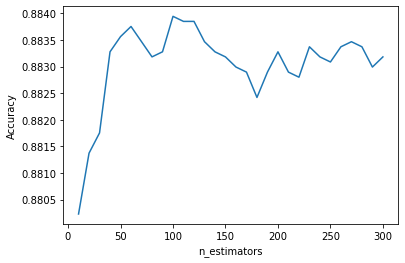

In [68]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_rf)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [69]:
#Calculando el número óptimo de estimadores evidenciado en la gráfica 
n_est_best = estimator_range[accuracy_scores_rf.index(max(accuracy_scores_rf))]
print('El número óptimo de estimadores es de ' + str(n_est_best))

El número óptimo de estimadores es de 100


Para este modelo de Random Forest se evidencia que el número óptimo de árboles a contruir es de 100, después de este dato el desempeño del modelo disminuye drásticamente

#### Calibrando el max depth

In [70]:
estimator_range = range(1,21)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=estimator, random_state=123, 
                                 min_impurity_decrease=0.001, n_jobs=-1)
    accuracy_scores_rf.append(cross_val_score(clf_rf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

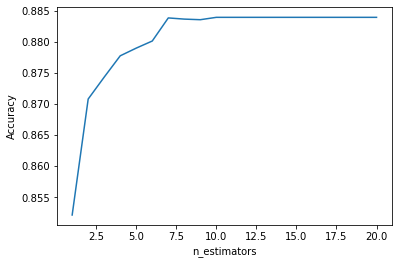

In [71]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_rf)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [72]:
#Calculando el número óptimo de profundidas evidenciado en la gráfica 
n_est_best = estimator_range[accuracy_scores_rf.index(max(accuracy_scores_rf))]
print('El número óptimo para la profundidad máxima de los arboles es de ' + str(n_est_best))

El número óptimo para la profundidad máxima de los arboles es de 10


A pesar de que la profundida máxima que nos indica la gráfica es 10, se va a hacer uso de una profundidad máxima de 7, ya que se evidencia que el cambio entre estas dos profundidades es muy pequeño y no es significativo. Además podría estar afectamdo el tiempo computacional más de lo que le estaría aportando al modelo.

#### Calibrando el max_features

In [73]:
estimator_range = range(1, X.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=123, 
                                 max_features= estimator, min_impurity_decrease=0.001, n_jobs=-1)
    accuracy_scores_rf.append(cross_val_score(clf_rf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

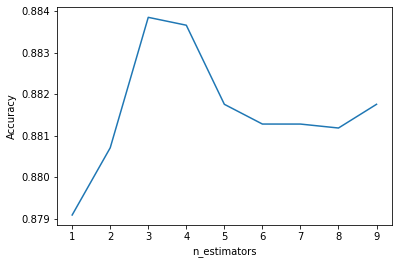

In [74]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_rf)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [75]:
#Calculando el número óptimo de features evidenciado en la gráfica 
n_est_best = estimator_range[accuracy_scores_rf.index(max(accuracy_scores_rf))]
print('El número óptimo para el máximo de features de los arboles es de ' + str(n_est_best))

El número óptimo para el máximo de features de los arboles es de 3


El número óptimo de features a usar es de 3, el cuál es muy cercano al logartimo de la cantidad total de features en el set, lo cuál da un valor de 2.2

#### Modelo con los parámetros optimizados

In [76]:
#Se implementan los parámetris optimizados teniendo en cuenta que:
#el número de estimadores es 100, la profundidad es 7 y los features son 3.
rf_skl_opt = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=123, 
                                 max_features= 3, min_impurity_decrease=0.001, n_jobs=-1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
rf_skl_opt.fit(X_train, y_train)
y_pred = rf_skl_opt.predict(X_test)

# Cálculo del desempeño del modelo 
acc_rf_skl_opt = metrics.accuracy_score(y_pred, y_test)

print('El Accuracy del modelo Random Forest con libreria y calibrando los parámetros es: ', acc_rf_skl_opt)

El Accuracy del modelo Random Forest con libreria y calibrando los parámetros es:  0.8874133949191686


Una vez se calibraron los parámetros del modelo de Random forest con libreria se evidencia un aumento en el Accuracy del modelo, sin embargo, no es el modelo que presenta un mejor desempeño

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [77]:
#Importar librerias
from xgboost import XGBClassifier

In [78]:
# Celda 7
xgb_skl = XGBClassifier()

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
xgb_skl.fit(X_train, y_train)
y_pred = xgb_skl.predict(X_test)

# Cálculo del desempeño del modelo
acc_xgb_skl = metrics.accuracy_score(y_pred, y_test)


print('El Accuracy del modelo XGBoost con libreria es: ', acc_xgb_skl)

El Accuracy del modelo XGBoost con libreria es:  0.8856812933025404


Con el modelo de XGBoost el desempeño del modelo es muy similar al de los anteriores, sin embargo no tiene el Accuracy más alto, es posible que calibrando los parámetros el modelo presente un mejor desempeño 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

#### Calibrando el learning rate

In [79]:
# Celda 6
estimator_range = range(0,20,1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_xgb = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_xgb = XGBClassifier(learning_rate = (estimator*0.05), random_state=123, n_jobs=-1)
    accuracy_scores_xgb.append(cross_val_score(clf_xgb, X, y, cv=5, scoring='accuracy').mean())

In [80]:
accuracy_scores_xgb

[0.41981896141019537,
 0.884992853739876,
 0.8832777513101477,
 0.882991900905193,
 0.8815626488804191,
 0.8808003811338733,
 0.8796569795140543,
 0.8790852787041448,
 0.8773701762744164,
 0.8769890424011434,
 0.8728918532634588,
 0.8732729871367317,
 0.8724154359218674,
 0.8741305383515959,
 0.8715578847070035,
 0.8686040971891377,
 0.8670795616960458,
 0.8675559790376368,
 0.8669842782277275,
 0.8666984278227728]

Text(0, 0.5, 'Accuracy')

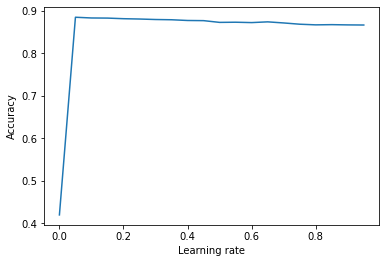

In [81]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
est_fin = [i*0.05 for i in estimator_range]
plt.plot(est_fin, accuracy_scores_xgb)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

In [82]:
n_est_best = estimator_range[accuracy_scores_xgb.index(max(accuracy_scores_xgb))]
print('El número óptimo para el learning rate de los arboles es de ' + str(n_est_best*0.05))

El número óptimo para el learning rate de los arboles es de 0.05


El modelo XGBoost toma base en el ensmablaje de árboles de decisión construidos secuencialmente con mejoras algoritmicas por lo que es importante calibrar el modelo learning rate ya que este parámetro será el encargado de controlar la ponderación de los nuevos árboles agregados al modelo.

#### Calibrando el gamma

In [83]:
estimator_range = range(0,20,1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_xgb = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_xgb = XGBClassifier(learning_rate = 0.05, random_state=123, gamma = estimator,
                            n_jobs=-1)
    accuracy_scores_xgb.append(cross_val_score(clf_xgb, X, y, cv=5, scoring='accuracy').mean())

In [84]:
accuracy_scores_xgb

[0.884992853739876,
 0.8852787041448309,
 0.8848975702715579,
 0.8848022868032397,
 0.8852787041448309,
 0.8854692710814674,
 0.8861362553596951,
 0.8860409718913769,
 0.8865173892329681,
 0.8862315388280134,
 0.8863268222963315,
 0.8861362553596951,
 0.8863268222963316,
 0.8857551214864221,
 0.8860409718913769,
 0.8851834206765126,
 0.8854692710814673,
 0.8859456884230585,
 0.8854692710814674,
 0.8859456884230585]

Text(0, 0.5, 'Accuracy')

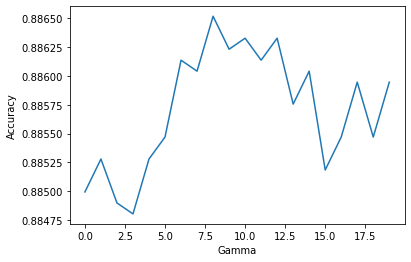

In [85]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
est_fin = [i for i in estimator_range]
plt.plot(est_fin, accuracy_scores_xgb)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

In [86]:
n_est_best = estimator_range[accuracy_scores_xgb.index(max(accuracy_scores_xgb))]
print('El número óptimo para el gamma es de ' + str(n_est_best))

El número óptimo para el gamma es de 8


Como lo hemos observado, el modelo XGBoost cuenta con algunas mejoras algorítmicas y dentro de estas se encuentra la regularización, es aquí donde entra en juego el parametro Gamma ya que con este parametro de regularización se buscará penalizar los modelos altamente complejos y combatir el sobreajuste en el modelo de XGBoost.

#### Calibrando el colsample_bytree

In [87]:
accuracy_scores_xgb.clear()

In [88]:
accuracy_scores_xgb

[]

In [89]:
estimator_range = range(0,20,1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for estimator in estimator_range:
    clf_xgb = XGBClassifier (learning_rate = 0.05, random_state=123, gamma = 8, colsample_bytree = estimator)
    accuracy_scores_xgb.append(cross_val_score(clf_xgb, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

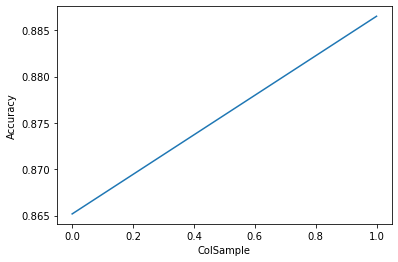

In [90]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
est_fin = [i for i in estimator_range]
plt.plot(est_fin, accuracy_scores_xgb)
plt.xlabel('ColSample')
plt.ylabel('Accuracy')

In [91]:
n_est_best = estimator_range[accuracy_scores_xgb.index(max(accuracy_scores_xgb))]
print('El número óptimo para colsamplebytree es de ' + str(n_est_best))

El número óptimo para colsamplebytree es de 1


El parametro "colsample_bytree" es la relación de submuestra de las columnas al construir cada árbol. Dicha relación o submuestreo se realiza una vez por cada arbol a realizar en el modelo y el paramatro se encuentra entre cero (0) y uno (1). De no poner explicitamente el valor del parametro en el modelo de XGBoost a realizar, se va a tomar por default un valor de uno (1). A l realizar el ejercico de calibración encontramos que el numero de submuestras optimas por arbol es de 1.

### Modelo XGBoost con parametros optimizados

In [92]:
#Se incorporan en el modelo XGBoost los parametros calibrados en pasos anteriores
xgb_skl = XGBClassifier (learning_rate = 0.05, random_state=123, gamma = 8, colsample_bytree = 1)

#Separación para el modelo
xgb_skl.fit(X_train, y_train)
y_pred = xgb_skl.predict(X_test)

#Predicciones del modelo XGBoost con parametros optimizados
f1_xgb_skl_opt = metrics.f1_score(y_pred, y_test)
acc_xgb_skl_opt = metrics.accuracy_score(y_pred, y_test)

#Ver resultados de las predicciones
print('F1 Score: ', f1_xgb_skl_opt)
print('Accuracy: ', acc_xgb_skl_opt)

F1 Score:  0.90752688172043
Accuracy:  0.8882794457274826


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

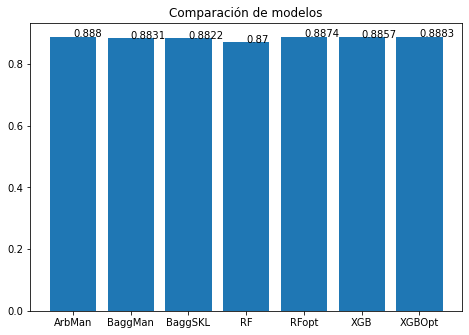

In [95]:
# Celda 8

#Mediante un gráfico se pretenderá observar el comportamiento de los diferentes modelos
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['ArbMan', 'BaggMan','BaggSKL','RF','RFopt','XGB','XGBOpt']
ejeY = [round(acc_arb_man,4),round(acc_bag_man,4),round(acc_bag_skl,4),round(acc_rf_skl,2) ,round(acc_rf_skl_opt,4),round(acc_xgb_skl,4),round(acc_xgb_skl_opt,4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

Como se puede evidenciar en el gráfico, los modelos presentan un nivel de acurracy similar, siendo el modelo XGBoost con parametros optimizados el que cuenta con un mejor desempeño ya que tiene un accuracy de 0.8883 seguido de el modelo de Bagging Manual (0.8877). Este resultado era el esperado y está de acuerdo con la teoría y práctica donde el modelo de XGBoost es uno de los mas utilizados pur su eficiencia y rendimiento ya que cuenta con mejoras algortimicas como los on la regularización (Parametros que se clabriraron para obtener le XGBoost con parametros optimizados).

En el ejericico evidenciamos la importancia de calibrar los parametros en los modelos ya que se observa una mejora tanto en XGBoost como en Bagging con parametros optimizados. Los modelos en general cuentan con un accuracy bueno pero la calibración de parametros puede marcar la diferencia 